# libraries


In [157]:
import pydub
import numpy as np
import sounddevice as sd
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
import cv2 as cv
import pandas as pd

# Part 1
## loading image
## detecting lines
## detecting notes
## compiling

In [133]:
# read image
TwinkleIm = cv.imread('Twinkle.png')

In [152]:
# detect lines
def LineDetector(input_im):
# convert image to gray image
    Gray_IM = cv.cvtColor(input_im,cv.COLOR_BGR2GRAY)
# detect edges
    t_lower = 50  # Lower Threshold
    t_upper = 200  # Upper threshold
#apertureSize is an optional parameter that is used to specify the order of the Sobel filter used
#to calculate the gradient in the Canny algorithm. The default value is 3 and its value should 
#be odd between 3 and 7. You can increase the Aperture size when you want to detect more detailed features.
    edges = cv.Canny(Gray_IM,t_lower,t_upper,apertureSize=3)

    IM_lines = cv.HoughLinesP(
                edges,
                1, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=50, # Min number of votes for valid line
                minLineLength=40, # Min allowed length of line
                maxLineGap=10 # Max allowed gap between line for joining them
                )
    lines_Y=[]
    for line in IM_lines:
        xx,ys,xf,yf=line[0]
        if(abs(xx-xf)>50):
            if(abs(ys-yf)<5):
                a=1
                for i in lines_Y:
                    if(abs(i-ys)<5):
                        a=0
                if(a or lines_Y==[]):
                    lines_Y.append(ys)
    for i in lines_Y:
        cv.line(Gray_IM, (0, i), (1600, i), (0,0,255), 2, cv.LINE_AA)
    lines_Y.sort()    
    return Gray_IM,lines_Y    
         


[27, 42, 58, 73, 88, 230, 246, 261, 277, 292, 434, 449, 465, 480, 495]


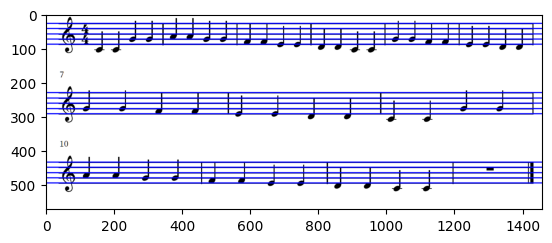

In [135]:
test_IM=TwinkleIm
Detected_IM,linesY=LineDetector(test_IM)
_ = plt.imshow(Detected_IM[:,:])
#_ = plt.xticks([])
#_ = plt.yticks([])
#_ = plt.box(0)
print(linesY)


In [136]:
def detectNotes(img, template, threshold):
    img2 = img.copy()
    
    w, h = template.shape[::-1]

    res = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    
    rects = list(zip(*loc[::-1]))
    rects = sorted(rects, key = lambda x: (x[0], x[1]))
    rects = np.asarray(rects)
    
    keep = [0]
    x_margin = 20
    y_margin = 20
    prev_x = rects[0][0]
    prev_y = rects[0][1]

    for i in range(1, rects.shape[0]):
        if (abs(rects[i][0] - prev_x) > x_margin or abs(rects[i][1] - prev_y) > y_margin):
            keep.append(i)
            prev_x = rects[i][0]
            prev_y = rects[i][1]

    rects = rects[keep]

    for pt in rects:
        cv.rectangle(img2, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)
        
    return rects, img2

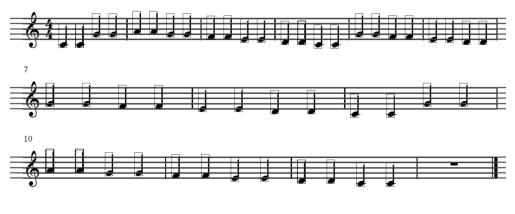

In [137]:
template = cv.imread("quarter (1).PNG", cv.IMREAD_GRAYSCALE)
gray = cv.cvtColor(TwinkleIm, cv.COLOR_BGR2GRAY)
threshold = 0.6

rects, img2 = detectNotes(gray, template, threshold)

_ = plt.imshow(img2, cmap = plt.cm.gray)
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.box(0)

In [149]:
# note class
class note :
    x=0
    y=0
    noteStr="" 
    dur=0   
class blunt :
    average=0
    lines=[]
    notes=[]
    def findNotesStr(self):
       # minY=min(self.lines)
       # for i in self.lines:
       #     i=i-minY
        for i in self.notes:
            if(i.y>self.lines[0]-15) :   

        
a=note()    
a.y=10
a.x=5
print(a.x+a.y)
           

15


In [156]:
import pandas as pd
print(min([2,3,4]))

2


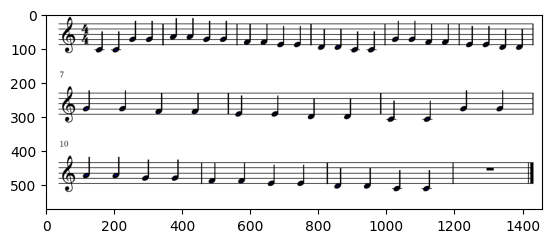

In [153]:
#detect notes
img = cv.imread('Twinkle.png')
def MakeNotes(input_img):
    result=[]
    ## line 
    junk1,lines =LineDetector(input_img)
    # create blunts
    bluntN=int(len(lines)/5)
    blunts=[]
    for i in range (bluntN):
        temp_blunt=blunt()
        temp_blunt.lines=[lines[5*i],lines[5*i+1],lines[5*i+2],lines[5*i+3],lines[5*i+4]]
        temp_blunt.average=sum(temp_blunt.lines)/len(temp_blunt.lines)
        blunts.append(blunt)
        
    ## note
    template = cv.imread("quarter (1).PNG", cv.IMREAD_GRAYSCALE)
    gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)
    threshold = 0.6
    rects,junk2= detectNotes(gray, template, threshold)
    for point in rects:
        temp_note=note()
        temp_note.x=point[0]+13
        temp_note.y=point[1]+61
        temp_note.dur=3
        for i in blunts:
            if(abs(i.average-temp_note.y)<75):
                i.notes.append(temp_note)
        image2 = cv.circle(input_img, (temp_note.x,temp_note.y), radius=0, color=(0, 0, 255), thickness=2)
        result.append(temp_note)
    
    


    return image2  
     
        
out=MakeNotes(img)
_ = plt.imshow(out, cmap = plt.cm.gray)

# Play functions

In [76]:
notes_base = 2**(np.arange(12)/12)*27.5
notes_duration = np.array([3200, 1600, 800, 400, 200, 100])*0.7
notes_ann = ['A', 'A#', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#']

def sin_wave(f, n, fs):
    x = np.linspace(0, 2*np.pi, n)
    ring = 30 
    xp = np.linspace(0, -1*(n*ring/fs), n)
    y = np.sin(x*f*(n/fs))*np.exp(xp)
    z = np.zeros([n, 2])
    z[:, 0] = y
    z[:, 1] = y
    return z

def play_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]*(fs/1000)), fs)
    sd.play(y, fs)
    sd.wait()
    return 

def put_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]*(fs/1000)), fs)
    return y

def get_music(music_notes, fs):
    m = []
    for item in music_notes:
        y = put_note(item[0], item[1], item[2], fs)
        m.append(y)
    m = np.concatenate(m, 0)
    return m

fs1 = 44100
music = [[8, 5, 3], [10, 5, 4], [10, 5, 4], [10, 5, 3], [10, 5, 3], [10, 5, 3], [10, 5, 3], [10, 5, 3], [10, 5, 3], 
        [11, 5, 4], [4, 5, 4], [11, 5, 4], [4, 5, 4], [11, 5, 4], [4, 5, 4], [11, 5, 4], [4, 5, 4], [3, 5, 3], 
        [8, 5, 4], [8, 5, 4], [8, 5, 3], [8, 5, 3], [8, 5, 3], [8, 5, 3], [8, 5, 3], [8, 5, 3], 
        [10, 5, 4], [3, 5, 4], [10, 5, 4], [3, 5, 4], [10, 5, 4], [3, 5, 4], [10, 5, 4], [3, 5, 4], [1, 4, 3]]

y = get_music(music, fs1)
sd.play(y, fs1)

In [142]:
Scale = [[3,4,3], [5,4,3], [7,4,3], [8,4,3], [10,4,3], [0,4,3], [2,4,3], [3,5,3], 
        [2,4,3], [0,4,3], [10,4,3], [8,4,3], [7,4,3], [5,4,3], [3,4,3]]

y = get_music(Scale, fs1)
sd.play(y, fs1)